In [70]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from kiwipiepy import Kiwi

from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD, NMF
from factor_analyzer.rotator import Rotator
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamodel import LdaModel
from gensim.test.utils import datapath
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis

from sklearn.model_selection import train_test_split

plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [2]:
lpay_b = pd.read_csv('./crawling/naver_blog_lpay.csv')
lpay_c = pd.read_csv('./crawling/naver_cafe_lpay.csv')
lpoint_b = pd.read_csv('./crawling/naver_blog_lpoint.csv')
lpoint_c = pd.read_csv('./crawling/naver_cafe_lpoint.csv')

In [3]:
lpay_b['keyword'] = 'lpay'
lpay_c['keyword'] = 'lpay'
lpoint_b['keyword'] = 'lpoint'
lpoint_c['keyword'] = 'lpoint'

In [4]:
corpora_df = pd.concat([lpay_b, lpay_c, lpoint_b, lpoint_c])
corpora_df.drop_duplicates(inplace=True)
corpora_df.reset_index(drop=True, inplace=True)

In [5]:
corpora_df.title.fillna('', inplace=True)
corpora_df.context.fillna('', inplace=True)

### Preprocessing

In [6]:
corpora_df.date.loc[corpora_df.date.map(lambda x: x.endswith('전'))] = '2022. 7. 4. 00:00'
corpora_df['date'] = pd.to_datetime(corpora_df['date'])

In [7]:
corpora_df['year'] = corpora_df.date.dt.year
corpora_df['month'] = corpora_df.date.dt.month

corpora_df['year_month'] = corpora_df[['year', 'month']].apply(lambda x: str(x[0])+'_'+str(x[1]), axis=1)

In [8]:
corpora_df.year_month = corpora_df.year_month.astype('category')
corpora_df.year_month = corpora_df.year_month.cat.reorder_categories([f'{i}_{j}' for i in sorted(corpora_df.year.unique()) for j in range(1,13)
                                                  if ((f'{i}_0{j}' in corpora_df.year_month.unique()) | (f'{i}_{j}' in corpora_df.year_month.unique()))])

In [9]:
corpora_df.context = corpora_df.context.map(lambda x: re.sub(r'[^\w\s]',' ',x))
corpora_df.context = corpora_df.context.map(lambda x: re.sub(r'\s+', ' ', x).lower())
corpora_df.context = corpora_df.context.map(lambda x: re.sub(r'\n+', '\n', x))

In [10]:
corpora = corpora_df[['title', 'context']].apply(lambda x: x[0]+' '+x[1], axis=1)

In [11]:
def extract_n(text):
    kiwi = Kiwi()
    kiwi.prepare()
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        if pos.startswith('N'):
            yield token
            
def extract_nv(text):
    kiwi = Kiwi()
    kiwi.prepare()
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        if pos.startswith('N') or pos.startswith('V'):
            yield token

------- run your code here -------

#### Noun & Verb

In [9]:
tfidf = TfidfVectorizer(tokenizer=extract_nv, max_features=5000)
tdm = tfidf.fit_transform(corpora)

In [10]:
word_count = pd.DataFrame({
    '단어':tfidf.get_feature_names(),
    '빈도':tdm.sum(axis=0).flat
})

/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
word_count = word_count.query('빈도 >= 10').reset_index(drop=True)

In [12]:
word_count.sort_values('빈도', ascending=False)

단어          빈도
738  포인트  436.937505
517    이  425.874792
352  상품권  327.935798
505    원  310.393971
758    하  290.521730
..   ...         ...
510   위치   10.061541
328    뽑   10.054699
428  아울렛   10.035633
118    놀   10.022037
617   중고   10.016406

[805 rows x 2 columns]

In [63]:
tdm_n_blog = tdm_n[corpora_df.query('type == "naver blog"').index]
word_count_n_blog = pd.DataFrame({'단어':tfidf_n.get_feature_names_out(), '빈도':tdm_n_blog.sum(axis=0).flat})

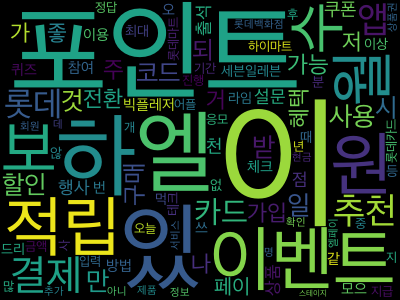

In [64]:
wc = WordCloud(max_words=100, width=400, height=300, font_path='Macintosh HD/시스템/라이브러리/Fonts/AppleSDGothicNeo.ttc')
count_dict = dict(zip(word_count_n_blog['단어'], word_count_n_blog['빈도']))
cloud = wc.fit_words(count_dict)
cloud.to_image()

In [25]:
with open('tfidf_lpoint_lpay.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
np.save('tdm_lpoint_lpay.npy', tdm, allow_pickle=True)
word_count.to_csv('word_count_lpoint_lpay.csv', index=False)

#### only Noun

In [80]:
tfidf_n = TfidfVectorizer(tokenizer=extract_n, max_features=5000)
tdm_n = tfidf_n.fit_transform(corpora)

In [81]:
word_count_n = pd.DataFrame({
    '단어':tfidf_n.get_feature_names(),
    '빈도':tdm_n.sum(axis=0).flat
})

/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [82]:
word_count_n = word_count_n.query('빈도 >= 10').reset_index(drop=True)
word_count_n.sort_values('빈도', ascending=False)

단어          빈도
659  포인트  458.791481
301  상품권  333.837257
440    원  326.047166
198   매입  280.448914
399    엘  261.089610
..   ...         ...
240    밥   10.047953
345  스토어   10.030152
397  에어팟   10.017231
490  자동차   10.013814
725    힘   10.003262

[726 rows x 2 columns]

In [83]:
with open('tfidf_lpoint_lpay_n.pkl', 'wb') as f:
    pickle.dump(tfidf_n, f)
np.save('tdm_lpoint_lpay_n.npy', tdm_n, allow_pickle=True)
word_count_n.to_csv('word_count_lpoint_lpay_n.csv', index=False)

### WordCloud

In [12]:
with open('tfidf_lpoint_lpay.pkl', 'rb') as f:
    tfidf_nv = pickle.load(f)
tdm_nv = np.load('tdm_lpoint_lpay.npy', allow_pickle=True).tolist()
word_count_nv = pd.read_csv('word_count_lpoint_lpay.csv')

In [13]:
with open('tfidf_lpoint_lpay_n.pkl', 'rb') as f:
    tfidf_n = pickle.load(f)
tdm_n = np.load('tdm_lpoint_lpay_n.npy', allow_pickle=True).tolist()
word_count_n = pd.read_csv('word_count_lpoint_lpay_n.csv')

nv

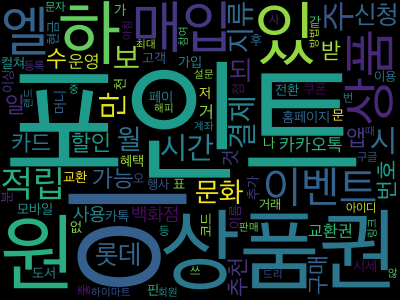

In [23]:
wc = WordCloud(max_words=100, width=400, height=300, font_path='Macintosh HD/시스템/라이브러리/Fonts/AppleSDGothicNeo.ttc')
count_dict = dict(zip(word_count_nv['단어'], word_count_nv['빈도']))
cloud = wc.fit_words(count_dict)
cloud.to_image()

In [27]:
tdm_blog = tdm_nv[corpora_df.query('type == "naver blog"').index]
word_count_blog = pd.DataFrame({'단어':tfidf_nv.get_feature_names(), '빈도':tdm_blog.sum(axis=0).flat})

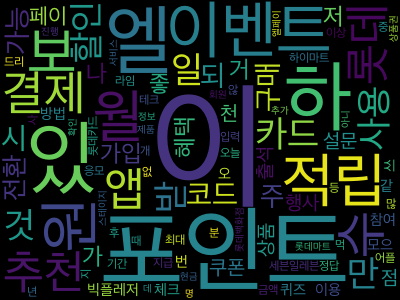

In [28]:
wc = WordCloud(max_words=100, width=400, height=300, font_path='Macintosh HD/시스템/라이브러리/Fonts/AppleSDGothicNeo.ttc')
count_dict = dict(zip(word_count_blog['단어'], word_count_blog['빈도']))
cloud = wc.fit_words(count_dict)
cloud.to_image()

Noun

all

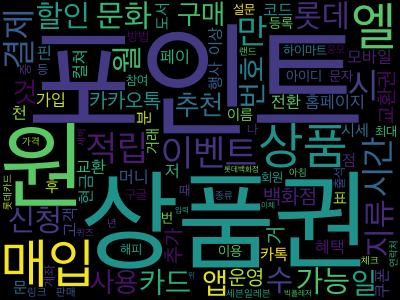

In [14]:
wc = WordCloud(max_words=100, width=400, height=300, font_path='Macintosh HD/시스템/라이브러리/Fonts/AppleSDGothicNeo.ttc')
count_dict = dict(zip(word_count_n['단어'], word_count_n['빈도']))
cloud = wc.fit_words(count_dict)
cloud.to_image()

cafe

In [15]:
tdm_n_cafe = tdm_n[corpora_df.query('type == "naver cafe"').index]
word_count_n_cafe = pd.DataFrame({'단어':tfidf_n.get_feature_names_out(), '빈도':tdm_n_cafe.sum(axis=0).flat})

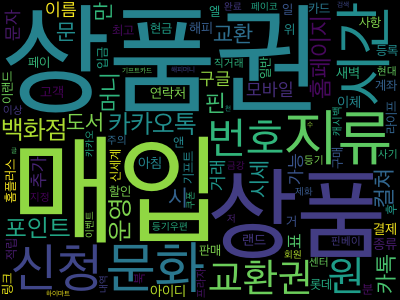

In [16]:
wc = WordCloud(max_words=100, width=400, height=300, font_path='Macintosh HD/시스템/라이브러리/Fonts/AppleSDGothicNeo.ttc')
count_dict = dict(zip(word_count_n_cafe['단어'], word_count_n_cafe['빈도']))
cloud = wc.fit_words(count_dict)
cloud.to_image()

- 카페는 주로 상품권 관련 단어들이 많이 나옴
  - 상품권, 상품, 매입, 교환권, 도서랜드, 백화점, 컬쳐, 문화, 지류 등
  - 상품권 판매 글이 많기 때문

blog

In [19]:
tdm_n_blog = tdm_n[corpora_df.query('type == "naver blog"').index]
word_count_n_blog = pd.DataFrame({'단어':tfidf_n.get_feature_names_out(), '빈도':tdm_n_blog.sum(axis=0).flat})

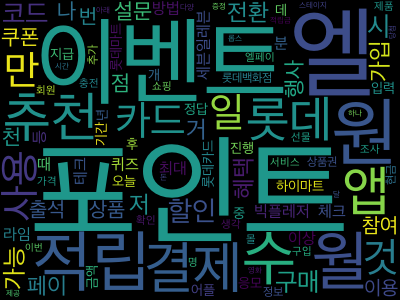

In [20]:
wc = WordCloud(max_words=100, width=400, height=300, font_path='Macintosh HD/시스템/라이브러리/Fonts/AppleSDGothicNeo.ttc')
count_dict = dict(zip(word_count_n_blog['단어'], word_count_n_blog['빈도']))
cloud = wc.fit_words(count_dict)
cloud.to_image()

- 블로그는 포인트, 이벤트, 적립, 할인이라는 단어가 많이 등장함

1월: 


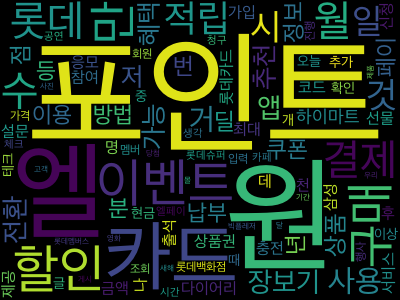

2월: 


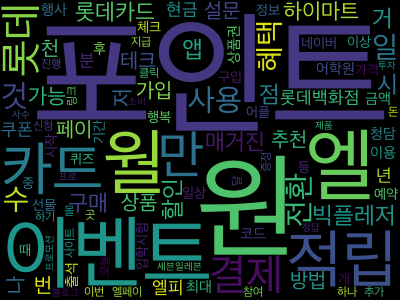

3월: 


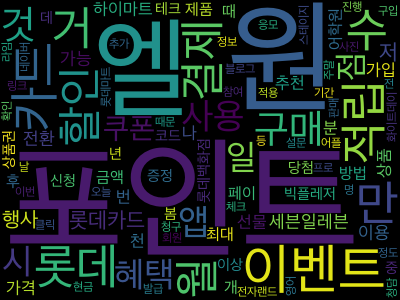

4월: 


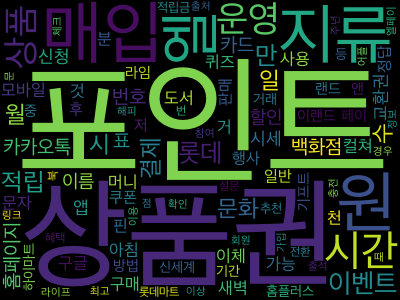

5월: 


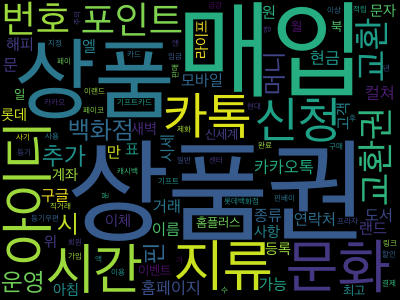

6월: 


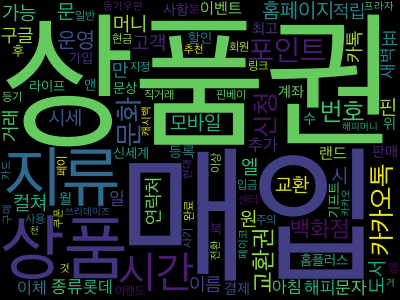

7월: 


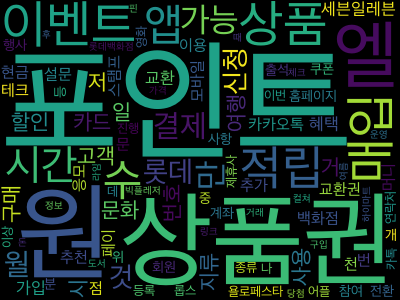

8월: 


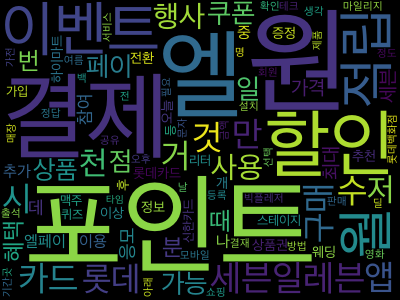

9월: 


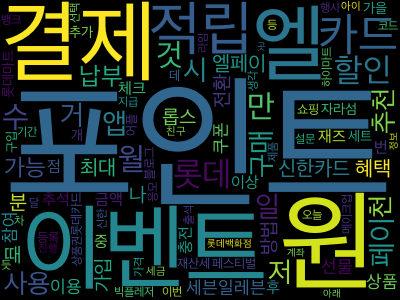

10월: 


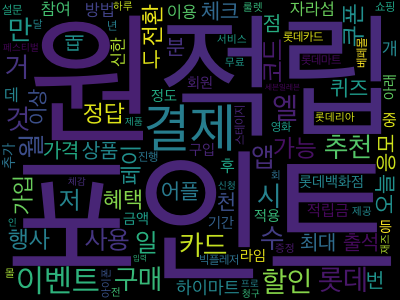

11월: 


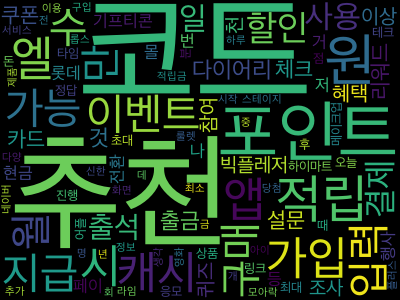

12월: 


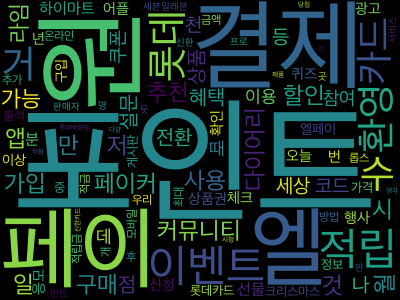

In [90]:
for m in range(1, 13):
    print(f'{m}월: ')
    globals()[f'tdm_n_month{m}'] = tdm_n[corpora_df.query(f'month == {m}').index]
    globals()[f'word_count_n_{m}'] = pd.DataFrame({'단어':tfidf_n.get_feature_names_out(), 
                                                   '빈도':globals()[f'tdm_n_month{m}'].sum(axis=0).flat})
    wc = WordCloud(max_words=100, width=400, height=300, font_path='Macintosh HD/시스템/라이브러리/Fonts/AppleSDGothicNeo.ttc')
    count_dict = dict(zip(globals()[f'word_count_n_{m}']['단어'], globals()[f'word_count_n_{m}']['빈도']))
    cloud = wc.fit_words(count_dict)
    display(cloud.to_image())

- 

### Topic Analysis

In [21]:
svd = TruncatedSVD(n_components=100, random_state=0)
svd.fit(tdm_nv)

TruncatedSVD(n_components=100, random_state=0)

#### 병렬 분석을 위한 차원 크기 결정

In [22]:
nrow, ncol = tdm_nv.shape

In [23]:
def resample(a):
    return np.random.choice(a, size=nrow)
np.random.seed(0)
d = np.apply_along_axis(resample, 0, tdm_nv.A) # 주어진 축에 따라 함수 적용

In [24]:
svd2 = TruncatedSVD(n_components=100, random_state=0)
svd2.fit(d)

TruncatedSVD(n_components=100, random_state=0)

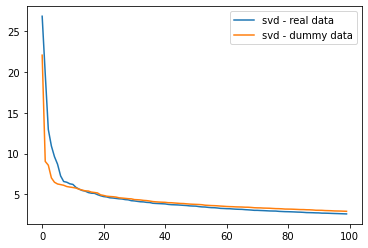

In [25]:
plt.plot(svd.singular_values_, label='svd - real data')
plt.plot(svd2.singular_values_, label='svd - dummy data')
plt.legend()
plt.show()

In [26]:
np.argwhere(svd.singular_values_ - svd2.singular_values_ <= 0)[0] # dummy data보다 성능이 낮은 구간: 이 차원 보다 더 낮게 설정

array([13])

#### LSA

In [27]:
svd = TruncatedSVD(n_components=12, random_state=0)
svd.fit(tdm_nv)

TruncatedSVD(n_components=12, random_state=0)

In [28]:
doc_topics_lsa = svd.transform(tdm_nv)

In [29]:
doc_topics = corpora_df[['type','year','month','year_month']]
doc_topics['topics_lsa'] = doc_topics_lsa.argmax(axis=1)

/var/folders/ty/d0l26xd500q6hk3ryfccwjy00000gn/T/ipykernel_6262/2791503426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doc_topics['topics_lsa'] = doc_topics_lsa.argmax(axis=1)


In [30]:
doc_topics.groupby('topics_lsa').topics_lsa.count()

topics_lsa
0     1044
1     3763
2        3
3      208
4      279
5      163
6      257
7       69
8       75
9       66
10      84
11      35
Name: topics_lsa, dtype: int64

In [31]:
for i in range(12):
    globals()[f'year_month_topic{i}'] = pd.DataFrame({'year_month':corpora_df.year_month})
    globals()[f'year_month_topic{i}'][f'topic{i}'] = doc_topics_lsa[:,i]
    globals()[f'year_month_topic{i}'] = globals()[f'year_month_topic{i}'].groupby('year_month')[f'topic{i}'].mean()
year_month_topic = pd.concat([globals()[f'year_month_topic{i}'] for i in range(12)], axis=1)

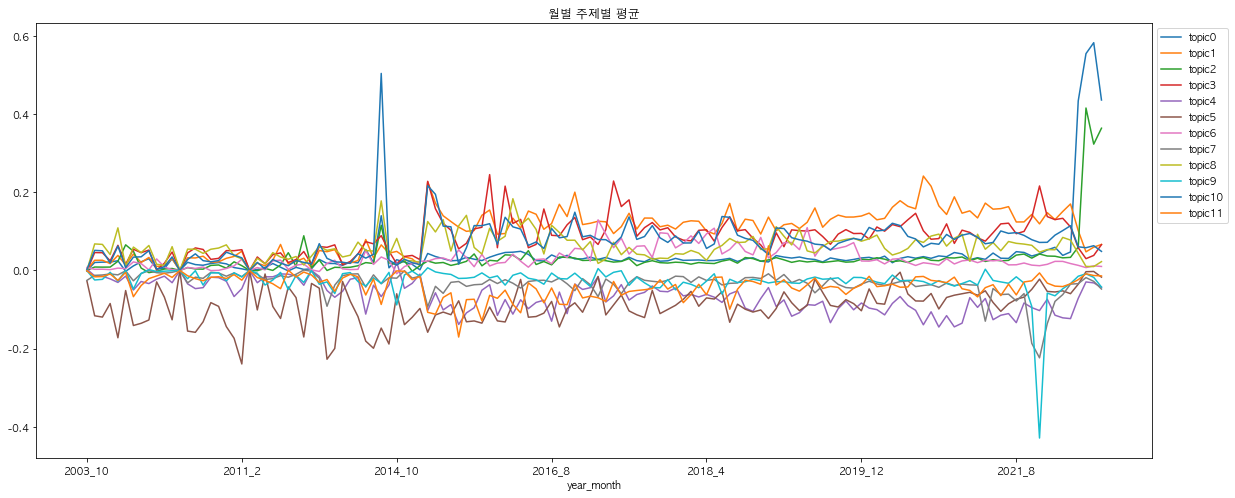

In [67]:
year_month_topic.plot(figsize=(20,8))
plt.title('월별 주제별 평균')
plt.legend(bbox_to_anchor=[1,1])
plt.show()

Rotate

In [33]:
rotator = Rotator()
rot = rotator.fit_transform(svd.components_.T)
loading = rot.T

In [47]:
doc_topics_rot = svd.transform(tdm_nv) @ rotator.rotation_

for i in range(12):
    globals()[f'year_month_topic{i}'] = pd.DataFrame({'year_month':corpora_df.year_month})
    globals()[f'year_month_topic{i}'][f'topic{i}'] = doc_topics_rot[:, i]
    globals()[f'year_month_topic{i}'] = globals()[f'year_month_topic{i}'].groupby('year_month')[f'topic{i}'].mean()
year_month_topic = pd.concat([globals()[f'year_month_topic{i}'] for i in range(12)], axis=1)

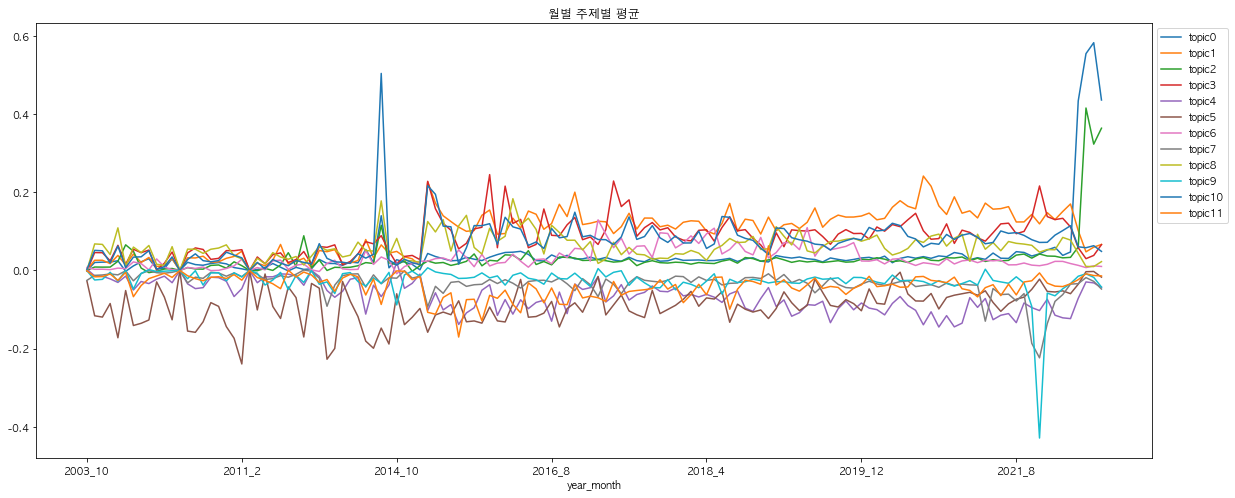

In [66]:
year_month_topic.plot(figsize=(20,8))
plt.title('월별 주제별 평균')
plt.legend(bbox_to_anchor=[1,1])
plt.show()

In [38]:
for i in range(12):
    globals()[f'topic{i}'] = pd.DataFrame({'word':tfidf_nv.get_feature_names_out(), 'loading':loading[i]})
    print(f'topic{i}:')
    display(globals()[f'topic{i}'].sort_values('loading', ascending=False).head(30))

topic0:


word   loading
1331    매입  0.323145
3864    지류  0.303929
2077   상품권  0.284653
3143    운영  0.258467
2462    시간  0.220102
4181  카카오톡  0.188413
4610     표  0.183592
3317    이름  0.165615
4898  홈페이지  0.165219
1682   백화점  0.165112
2076    상품  0.159481
2485    시세  0.155777
1706    번호  0.152675
1501    문화  0.151849
364    교환권  0.144861
2086    새벽  0.139068
2680    아침  0.133857
3351    이체  0.133366
1497    문자  0.129916
1429   모바일  0.119886
368     구글  0.110693
919     도서  0.109981
4237    컬쳐  0.107255
4692     핀  0.105929
2553    신청  0.102479
3310   이랜드  0.098068
1350    머니  0.092475
525    기프트  0.088408
2751     앤  0.087974
4676     피  0.086733

topic1:


word   loading
195      결제  0.479280
3326    이벤트  0.442323
2873      엘  0.312669
4545     페이  0.288693
4588    포인트  0.190423
4013      천  0.186533
2877    엘페이  0.155735
3583     적립  0.149976
3164      원  0.139979
3182      월  0.116474
2213  세븐일레븐  0.113301
3275     응모  0.107002
2562   신한카드  0.085970
2460      시  0.085445
2754      앱  0.082657
3408      일  0.081732
1281      만  0.080572
4079     최대  0.079882
3292      이  0.070236
2560     신한  0.064009
3974     참여  0.063031
4708      하  0.062027
4931     환영  0.059947
833      당첨  0.056371
3331     이상  0.056339
1401      명  0.054449
4222   커뮤니티  0.053016
4494      판  0.052496
484      기간  0.051770
1623      받  0.046967

topic2:


word   loading
4185     카톡  0.288366
2077    상품권  0.236164
2664    아이디  0.228739
363      교환  0.214828
241      고객  0.199491
2918    연락처  0.198664
4092     추가  0.196333
2076     상품  0.183817
3745     종류  0.178358
1501     문화  0.169176
1331     매입  0.159553
4852     현금  0.159342
3759      주  0.153305
2553     신청  0.152907
237      계좌  0.133789
2021     사항  0.131744
1491      문  0.124838
1033     등록  0.122066
3199      위  0.121812
4693    핀베이  0.109652
3897    직거래  0.108624
1030     등기  0.106323
3886     지정  0.102960
3442     입금  0.099577
3787     주의  0.097737
12       가능  0.093604
2231     센터  0.093325
4180    카카오  0.087410
526   기프트카드  0.081633
4692      핀  0.076452

topic3:


word   loading
2181   설문  0.504564
1098   라임  0.445273
4588  포인트  0.273853
3723   조사  0.256445
2754    앱  0.193556
3583   적립  0.167267
4382   테크  0.148035
4098   추천  0.140843
4117   출석  0.134150
1436   모으  0.132881
3292    이  0.132549
3460    있  0.123589
2813   어플  0.108407
33     가입  0.108241
2300    수  0.103758
3974   참여  0.103437
606    나무  0.102257
4708    하  0.087987
4045   체크  0.084267
1623    받  0.078751
2873    엘  0.076741
2880   엘피  0.065565
1504    물  0.065369
4322   키우  0.064525
1422   모두  0.058482
3326  이벤트  0.052160
1753    보  0.049715
4947   회원  0.049013
4258   코드  0.047676
3759    주  0.046220

topic4:


word   loading
3326   이벤트  0.173667
2873     엘  0.094319
4545    페이  0.088242
195     결제  0.080759
4588   포인트  0.066856
4258    코드  0.060056
2877   엘페이  0.057204
4292    퀴즈  0.039619
2137   서비스  0.039407
3443    입력  0.036560
4098    추천  0.036242
3974    참여  0.035443
3712   제휴사  0.028186
17     가맹점  0.027712
3656    정답  0.027530
1033    등록  0.026432
1649    방법  0.026168
1434   모아락  0.025979
1999    사용  0.024547
1939  빅플레저  0.024487
1331    매입  0.023706
3391    인증  0.022615
633     납부  0.022440
1896   블로그  0.022310
4055    초대  0.022210
3864    지류  0.021335
3850    지급  0.020987
3337    이용  0.020348
3275    응모  0.020185
3629    전환  0.019875

topic5:


word   loading
4588    포인트  0.176396
3583     적립  0.172119
4173     카드  0.132886
3164      원  0.132408
2873      엘  0.118979
1281      만  0.115521
2181     설문  0.106995
4772     할인  0.101243
3182      월  0.093610
1098     라임  0.081377
1184   롯데카드  0.068255
2460      시  0.065735
3326    이벤트  0.060192
4880     혜택  0.056812
4258     코드  0.052713
3723     조사  0.050404
4098     추천  0.046944
33       가입  0.046082
4079     최대  0.046055
1630     발급  0.043785
484      기간  0.043370
2580     실적  0.043334
1166     롯데  0.039361
4013      천  0.038060
2618  쓰리데이즈  0.037543
4024     청구  0.036541
3584    적립금  0.035136
3683     제공  0.033092
3331     이상  0.032297
4755     한도  0.031997

topic6:


word   loading
1939  빅플레저  0.646903
2413  스테이지  0.485507
3182     월  0.374290
295     공연  0.127184
1323   매거진  0.125360
1379  메이크업  0.116845
4449    특집  0.113325
3275    응모  0.105993
1883    뷰티  0.100386
3408     일  0.069667
833     당첨  0.063001
4273   콘서트  0.059125
1163    롭스  0.055477
1468    무대  0.052913
2873     엘  0.050424
4966    휘성  0.049333
4266   코엑스  0.048540
675      년  0.047479
3164     원  0.046315
4464    티켓  0.042040
2294     쇼  0.041197
30      가을  0.038528
683     노래  0.037925
4588   포인트  0.037686
3488   자우림  0.034315
3751     좋  0.034075
3744    종료  0.034055
1941  빅플레져  0.033408
3665   정세운  0.032948
1519   뮤지컬  0.032943

topic7:


word   loading
2873     엘  0.130929
2181    설문  0.118524
3723    조사  0.089095
1098    라임  0.075931
195     결제  0.042561
3326   이벤트  0.037084
4173    카드  0.032850
1281     만  0.032137
1045     딜  0.026991
2877   엘페이  0.026201
2077   상품권  0.022244
3759     주  0.020927
3164     원  0.020751
4013     천  0.019253
2413  스테이지  0.018309
2154    선물  0.018305
1033    등록  0.017820
1184  롯데카드  0.016554
4130    충전  0.015771
2880    엘피  0.015700
1434   모아락  0.015424
1497    문자  0.015255
129     거래  0.015024
3443    입력  0.014544
3275    응모  0.013097
1706    번호  0.012117
4546   페이백  0.011715
1011    드리  0.011707
4852    현금  0.011687
3659    정보  0.011559

topic8:


word   loading
4173    카드  0.548893
195     결제  0.269958
4772    할인  0.196770
1184  롯데카드  0.162465
4880    혜택  0.143078
3460     있  0.140427
3337    이용  0.138356
1630    발급  0.127847
1999    사용  0.124354
3583    적립  0.121143
2580    실적  0.111357
2137   서비스  0.108249
3683    제공  0.103674
1166    롯데  0.098339
2550    신용  0.097710
474     금액  0.097134
2300     수  0.093487
17     가맹점  0.085595
3292     이  0.081890
633     납부  0.079305
4771    할부  0.077743
2936   연회비  0.070468
983      되  0.069754
3190    웨딩  0.069405
1033    등록  0.067433
1270  마일리지  0.066014
12      가능  0.059745
3629    전환  0.059511
1028     등  0.053426
4755    한도  0.052685

topic9:


word   loading
3583     적립  0.136454
4292     퀴즈  0.133790
3656     정답  0.101968
4117     출석  0.069383
2181     설문  0.056650
1098     라임  0.052335
1166     롯데  0.050527
1436     모으  0.046343
3182      월  0.045578
4288     쿠폰  0.044274
2813     어플  0.040112
3460      있  0.038250
3408      일  0.037429
4045     체크  0.032692
4708      하  0.032604
2213  세븐일레븐  0.032060
4588    포인트  0.032059
4382     테크  0.030514
1504      물  0.029646
2996     오늘  0.028591
1698      번  0.028394
2880     엘피  0.026172
1213     리브  0.026106
1262     마시  0.025799
1380    메이트  0.024968
606      나무  0.023913
2611      쏠  0.023062
1537     미션  0.022696
4480   파스퇴르  0.022611
1331     매입  0.022578

topic10:


word   loading
4588    포인트  0.531382
3629     전환  0.445197
2873      엘  0.341721
1166     롯데  0.181976
1999     사용  0.171095
3460      있  0.099675
2077    상품권  0.098460
1649     방법  0.088645
4130     충전  0.083356
1174  롯데백화점  0.079403
12       가능  0.068559
4708      하  0.065937
2003    사용처  0.064984
3712    제휴사  0.063735
2154     선물  0.062346
2300      수  0.060716
1281      만  0.058937
2618  쓰리데이즈  0.056730
1270   마일리지  0.056210
2076     상품  0.053185
2614      쓰  0.053011
633      납부  0.052806
3704   제주항공  0.049396
4852     현금  0.047220
3637      점  0.045552
1759     보내  0.045546
3582     적금  0.045104
373      구매  0.043091
3041    온라인  0.042216
4957      후  0.041509

topic11:


word   loading
195     결제  0.268361
4545    페이  0.230861
3164     원  0.174156
2754     앱  0.156421
1939  빅플레저  0.126287
3583    적립  0.116258
4931    환영  0.111288
4222  커뮤니티  0.098303
4382    테크  0.097680
2413  스테이지  0.096627
4117    출석  0.093221
1436    모으  0.079508
4551   페이커  0.077153
2560    신한  0.069754
2562  신한카드  0.067742
4045    체크  0.064298
4588   포인트  0.062015
2813    어플  0.060026
670    네이버  0.059339
126      거  0.058128
2214    세상  0.047283
4039    체감  0.044162
1684    뱅크  0.043413
4130    충전  0.042197
4494     판  0.040271
2614     쓰  0.040126
3582    적금  0.039103
4852    현금  0.037962
1434   모아락  0.037635
2877   엘페이  0.036480

topic0:


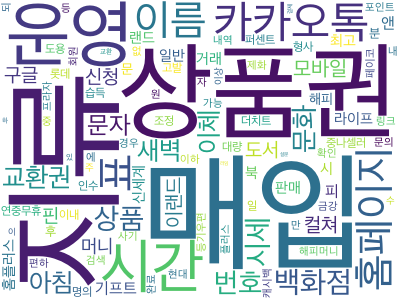

topic1:


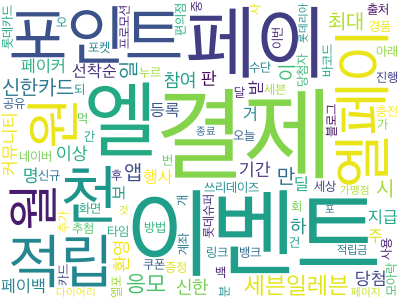

topic2:


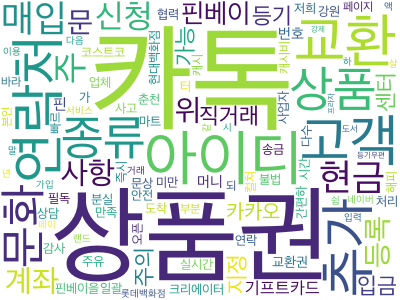

topic3:


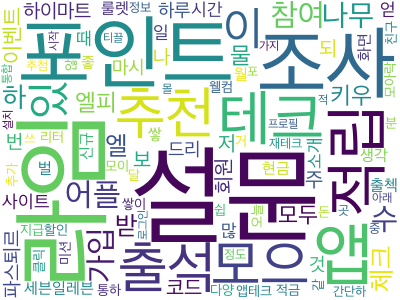

topic4:


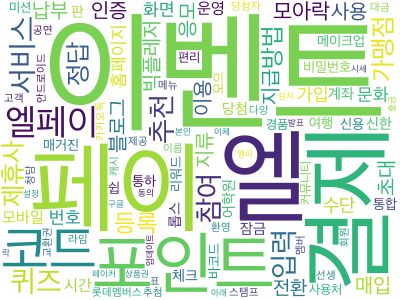

topic5:


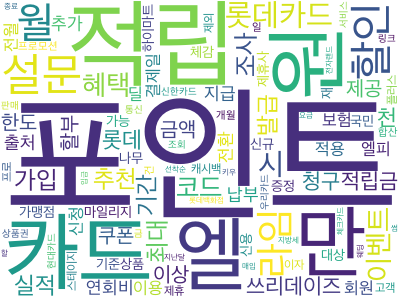

topic6:


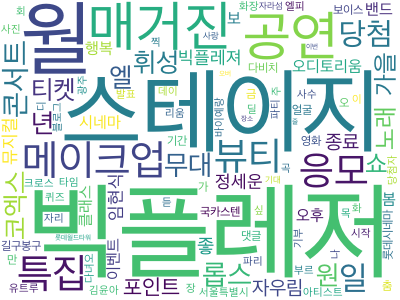

topic7:


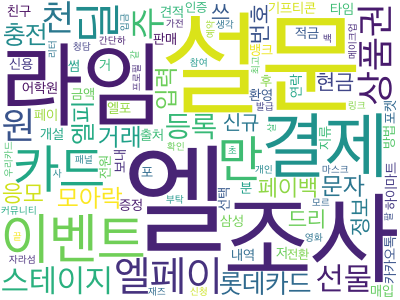

topic8:


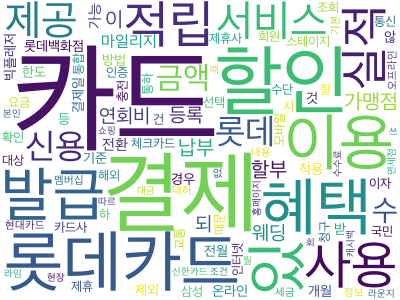

topic9:


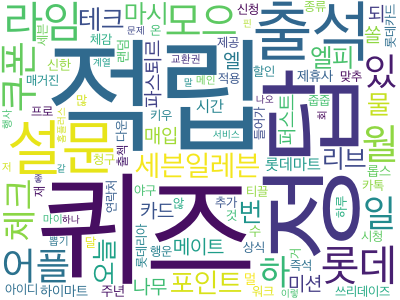

topic10:


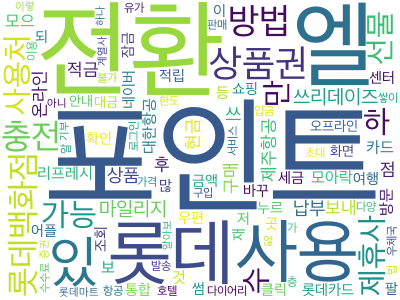

topic11:


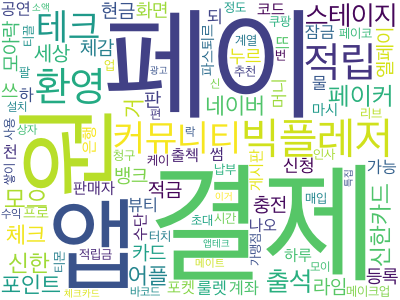

In [91]:
for i in range(12):
    globals()[f'topic{i}'] = pd.DataFrame({'word':tfidf_nv.get_feature_names_out(), 'loading':loading[i]})
    print(f'topic{i}:')
    wc = WordCloud(max_words=100, width=400, height=300, font_path='Macintosh HD/시스템/라이브러리/Fonts/AppleSDGothicNeo.ttc',
              background_color='white')
    count_dict = dict(zip(globals()[f'topic{i}']['word'], globals()[f'topic{i}']['loading']))
    cloud = wc.fit_words(count_dict)
    display(cloud.to_image())

- Topic0
  - 매입, 지류, 상품권, 운영, 시간, 카카오톡, 백화점, 상품, 번호, 문화, 교환권, 구글, 도서, 걸쳐, 이랜드, 머니 등 상품권 관련 단어 많음
- Topic1
  - 결제, 이벤트, 엘페이, 포인트, 적립, 세븐일레븐, 응모, 신한카드, 참여, 당첨, 받 단어 많음
- Topic2
  - 카톡, 상품권, 아이디, 교환, 상품, 문화, 매입, 현금, 직거래, 기프트카드 단어 많음
- Topic3
  - 설문, 포인트, 조사, 적립, 추천, 출석, 모으, 가입, 참여, 나무, 하, 체크, 받, 이벤트 단어 많음
- Topic4
  - 이벤트, 엘페이, 결제, 포인트, 코드, 퀴즈, 서비스, 입력, 추천, 참여, 제휴사
- Topic5
  - 포인트, 적립, 카드, 설문, 할인, 롯데카드, 아벤트, 혜택, 추천
- Topic6
  - 빅플레저, 스테이지, 공연, 매거진, 메이크업, 응모, 뷰티, 당첨, 콘서트, 롭스, 무대, 휘성, 코엑스, 티켓, 노래, 포인트
- Topic7
  - 설문, 조사, 결제, 이벤트, 카드, 상품권, 응모, 페이백
- Topic8
  - 카드, 결제, 할인, 롯데카드, 혜택, 이용, 발급, 사용, 적립, 실적, 서비스, 제공, 신용, 가맹점, 납부, 할인, 연회비, 마일리지, 전환, 한도
- Topic9
  - 적립, 퀴즈, 정답, 출석, 설문, 모으, 쿠폰, 어플, 체크, 세븐일레븐, 포인트
- Topic10
  - 포인트, 전환, 롯데, 사용, 상품권, 충전, 롯데백화점, 가능, 사용처, 제휴사, 선물, 쓰리데이즈, 마일리지, 상품, 쓰, 납부, 제주항공, 현금, 구매
- Topic11
  - 결제, 페이, 원, 앱, 빅플레저, 적립, 환영, 커뮤니티, 테크, 스테이지, 출석, 페이커, 신한카드, 체크, 포인트

In [49]:
corpora_df['topic_lsa_rot'] = doc_topics_rot.argmax(axis=1)

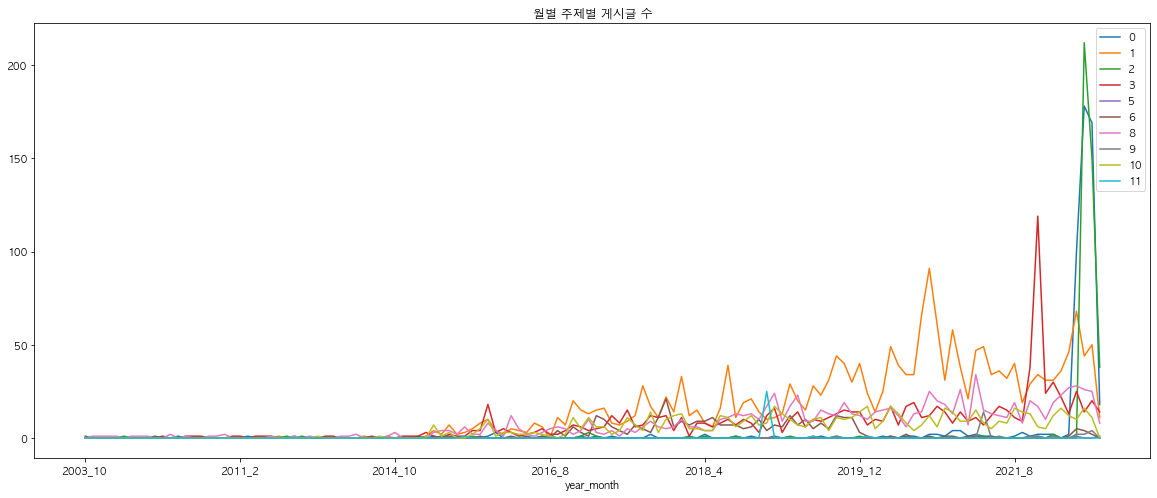

In [61]:
pd.crosstab(corpora_df.year_month, corpora_df.topic_lsa_rot).plot(figsize=(20,8))
plt.title('월별 주제별 게시글 수')
plt.legend(bbox_to_anchor=[1,1])
plt.show()

/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


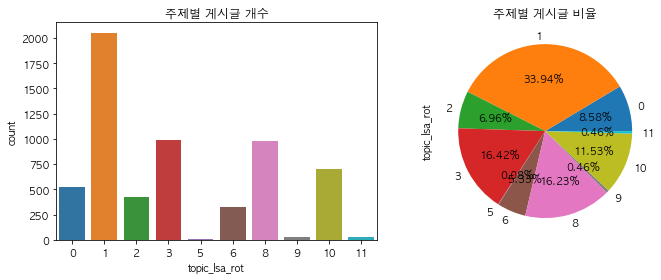

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(corpora_df.topic_lsa_rot, ax=axes[0])
corpora_df.groupby('topic_lsa_rot').topic_lsa_rot.count().plot.pie(autopct='%.2f%%', ax=axes[1])
axes[0].set_title('주제별 게시글 개수')
axes[1].set_title('주제별 게시글 비율')
plt.tight_layout()
plt.show()

In [94]:
lst = [1,3,8,10]
corpora_df.query('topic_lsa_rot in @lst').shape[0]/corpora_df.shape[0]

0.7811776381078399

- 1, 3, 8, 10 순서로 주제가 많음
  - 1: 포인트 적립 이벤트 관련 게시글
  - 3: 설문조사, 포인트 적립 관련 게시글
  - 8: 카드 결제 이벤트 관련 게시글
  - 10: 포인트 사용, 전환 관련 게시글
- 위 주제들이 전체 게시글의 78% 이룸
- 이를 통해 엘페이 고객 들은 이벤트, 포인트 사용 관련해서 관심이 많음을 알 수 있다.

In [184]:
for t in corpora_df.query('topic_lsa_rot == 1').title:
    print(t)

Lpay 사용해서 엘포인트 모아보기 2편_Lpay 사용(신한 더모아, 차이카드)
LPAY 신한 체크카드
(LPAY) 엘페이 첫 결제하면 엘포인트 1만P 적립해 줘요! (ft. 1만원 공짜쇼핑 가능)
앱테크 추천 엘포인트 사용처 적립 방법 엘페이 lpay 결제하기
엘페이 (엘포인트) Lpoint Lpay 통합, 퇴보한 앱 UI
[혜택챙겨] 재산세 납부 이벤트 - LPAY활용 중복혜택 1.2% 챙기기 (서울시/부산시)
LPAY 엘페이 신한체크카드 1만원 이벤트
[결제선생 x 엘페이 LPAY] 선착순 1,000명 엘포인트 LPOINT 3,000포인트 적립 이벤트!
우리카드 * LPAY 이벤트, 1만원 이상 첫결제 2천 포인트(-4.30)
롯데온 X Lpay 이벤트
세븐모닝세트(Lpay+Lpoint결제시 50%)
[야놀자] 신세계 이마트 상품권 5만원권 10% 페이백(~4/30) + 신한 Lpay 혜택
세븐일레븐#Lpay이벤트#룰렛이벤트#1만원이상결제시 #엘포인트환급
신한카드 PayFAN에서 Lpay로 결제하면 최대 7천포인트 적립!
롯데페이/LPay/결제/Lpoint/엘페이
세븐일레븐 Lpay 10% 할인, 롯데마트 네이버페이 20% 할인
밀리터리버거 Lpay결제시 페이백 이벤트
7-Eleven(세븐일레븐) 11월 행사 및 이벤트 할인 내용 빼빼로데이 페레로로쉐 페이코인 LPAY 할인
롯데 lpay 3% 적립 일부취소 포인트 미지급
롯데호텔 이그제큐티브타워 lpay 할인/아고다 무료취소/에고이스트x아옳이 원피스
재산세...Lpay로 납부하기 이벤트...삶
세금 lpay로 납부시 l.point 지급
쿠첸 4인용 압력밥솥 CJH-PA0404iD 단독특가, 6인용 열판밥솥 할인, 하이마트 LPOINT, LPAY 페이백 진행
신한카드 마이샵 Lpay 5만원
롯데시네마 갈 때 Lpay 롯데카드로 결제하고 엘포인트 혜택 챙겨가요♥
[롯데온] 10월 단 하루 2만 이상 Lpay 결제 시 최대 30% 적립
송도맥주축체 안드로이드 결제 단말기 V1s for LPAY Service


In [190]:
for t in corpora_df.query('topic_lsa_rot == 3').context:
    print(t[-100:])
    print('')

활 지난 달에도 가능했던 것 같은데 늦게 알았다 롯데슈퍼는 월의 1일차 부터 참여하면 혜택이 더 좋다 이번 달 모두 출석하면 500p 100 당첨 이런 혜택 너무 좋음 감사합니다 

lpay we ll have fun today as long as we re together 외워서 흘러나올때 아기에게 불러주면 좋을 것 같아서 설명서에 있는 노래가서 첨부했어용 

있는 상품이었는데 적은금액이긴 하나 5개월만인가 25 의 수익이 난다니 인플레가 무서운 것인지 거품인 것인지 신기할 따름이다 그래서 오늘은 뱅크시 작품을 11조각정도 살 계획이다 

첵하면 한 30분정도 걸려요 이걸 왜하나 싶지만 그래도 이게 쌓여서 저의 지출방어에 큰 도움이 되고 있으니 한번 해보심이 좋을듯 하네요 나의앱테크 앱출첵 출석체크 앱테크모음 앱테크

되면 블로그에 포스팅 드리겠습니다 케이뱅크 신규가입에 관심 있으시면 아래 링크로 가입 부탁드립니다 케이뱅크에 초대합니다 혜택 좋고 간편한 제1금융권 은행 m kbanknow com

서 좌담회까지 다양한 설문기회 www panel co kr 혹시 설문조사 앱이 선택이 고민되신다면 엠브레인이 여러분의 고민을 해결해줍니다 방문을 원하시면 위의 링크 클릭 바랍니다 

많이 판매되고 있지만 대기줄이 길기 때문에 빠른 판단이 필요합니다 사진 중 일부는 지난해에 직접 찍은 것이고 일부는 맥주축제 홈페이지와 페이스북에서 가져온 것입니다 참고 바랍니다 

송 15ach 게이밍3 노트북 o gaming3 15 r5 3060 amd r5 5600h 8gb 256gb rtx3060 프리도스 39 6cm 블랙 m e himart co kr

ㅇ 프라다 포코노 나일론 버킷백 존예 ㄷㅈㅇㅇ 내돈내산 싸게 사서 행복함 ㅅㅈㅇㅇ 시아준수 떡밥 좀ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ 자꾸 허해서 돈쓰잖아 

보유 중 이전에는 출석체크 포인트도 1 2p라도 더 높았고 롯데마트 롯데슈퍼 등에서도 출석체크가 가능했는데 현재 기준은 없어졌다 없어졌다가도 다시 

In [191]:
for t in corpora_df.query('topic_lsa_rot == 8').title:
    print(t)

롯데카드 LPAY by 롤라 신규발급 14만 포인트 캐시백 이벤트 2022년 4월 L.point
Lpay 사용해서 엘포인트 모아보기 1편_Lpay 등록(신한 더모아, 차이카드)
롯데호텔멤버십)트레비클럽 가입하고 혜택챙기자!!(이벤트확인+Lpay by 롤라카드로14만점 챙기기)
신혼 혼수 가전 장만하기 -가전 구매-롯데백화점 Lpay 카드 이용
Lpay 엘페이 신한카드 기본적립 무제한 특별 추가 적립 최대 7프로 포인트 적립 혜택 추천
(롯데카드전문가추천) MOST(모스트)에서 LPAY(엘페이)결제하면 리터당 200원 할인 - 주유 할인
[라이브네이션코리아 선예매 방법 ; LANY 내한공연(Live in Seoul 2019) / YES24 티켓팅 상세 방법, 카드결제 Lpay 사용하기]
헤지스 레이디스 바캉스룩 호캉스 반팔 티셔츠로 비치웨어 준비하자 !
LPAY 하나 체크카드 출시 이벤트
롯데월드 Lpay로 결제하면 반값할인, 슈퍼 그뤠잇!
헤지스 로고 카라티셔츠 여름 반팔 폴로 티셔츠 할인받아 쇼핑하자 !
아임유 키오스크 인지도 1위 이유?
동탄 롯데백화점 혼수가전 입주가전 그랜드오픈행사 롯데 9.5% 적립 삼성디지털프라자 동탄롯백 비스포크 할인율 ㄷㄷ
호캉스추천 롯데시티마포 싸게예약하는방법 & 숙박후기
체크카드 신규 발급 추천 / KB국민카드 위글위글 첵첵 체크카드
삼성 980 PRO 1TB
[멀버리] 연핑크 앰벌리 사첼과 연핑크 카드지갑- 에비뉴엘 P쇼핑데이에 완전득템🛍👜
롯데 롤라카드 및 이벤트 소개 (2022.2.2 작성)
2022 롯데백화점 에비뉴엘 프라이빗 쇼핑데이 5/23(월) 초대장 혜택
카드리빌딩:롯데카드 해지하고 삼성카드 만들기
[KB국민카드] L. POINT 제휴 적립 이벤트
코로나 여행, 전남순천 선암사(세계문화유산)
[더모아&신한카뱅] 활용기 3-1탄. 나마네카드 구입
롯데 창원 스니커바 마르니 MARNI 샌들 입고 안내
SK텔레콤 멤버십 주유 할인 MOST & Carlife 활용기
원하는 상품을 LF몰 스토어에서 최저가로 구매하는 꿀팁

In [192]:
for t in corpora_df.query('topic_lsa_rot == 10').title:
    print(t)

롯데멤버스 L.pay 착한 장보기 와우 좋네요 롯데멤버스 #착한장보기 #LPOINT #롯데슈퍼 #Lpay
해운대 백병원 푸드코트 메뉴(2022.04)
다우니 실내건조 섬유유연제 핫딜은 롯데온 퍼스트먼데이 무료 엘포인트 받고 사자
버라이즌 S6 OK7 2G/LTE 오토스위치
돈버는 어플 '앱테크' 생활 필수 어플 1탄 : 엘포인트
우리에 이어 하나... L.POINT 두번째 체크카드 등장임?
더모아 사용시 999원 맞추기 꿀팁
롯데상품권 엘포인트로 전환하기
편의점 ATM 수수료 무료 (모든 은행, 세븐일레븐)
인스타그램, 엘페이, 엘포인트 사용법 강의
롯데백화점 노원점 특강 & 관악점 직원 교육
롯데 창원 스니커바 발렌시아가 BALENCIAGA 21FW 스니커즈 안내
L.POINT 엘포인트 충전 환불 방법
우리카드 카드의정석 엘포인트(L.POINT) 엘포인트전환 꿀팁 체크!
캐시워크돈버는퀴즈롯데on
롯데 창원 스니커바 AMI 아미 21 FW 스니커즈 안내
[부수입 꿀팁] 신세계상품권 온라인에서 사용하기
[상테크] 해피머니 상품권을 페이코 전환 및 현금화 하기
신세계 상품권 ssg머니로 전환하는 법
엘포인트 (L.POINT) 사용처 세금납부도 가능
롯데 광고음악 작업
나나진/ 일상의 패션에 자수를 더한 자수스타일 리스트
자료로 알아 봄
베이비붐 세대는 SPA를 입는다?!
L.POINT를 대한항공 마일리지로 전환하면, 10% 페이백과 파리 왕복항공권을 드립니다!
집 운동의 모든 것
🎬엘터뷰 8화ㅣ엘터뷰 촬영 뒷이야기!!
엘포인트 선물하는 방법
전환장애(Conversion disorder,히스테리아 )
롯데멤버스, L.POINT 고객 소비 트렌드 측정하는 ‘L.POINT 소비지수’ 발표
롯데멤버스㈜, 우리은행과 L.POINT 제휴 위한 업무협약(MOU) 체결
L.POINT, 통합멤버십부문 ‘2016 소비자선정 스타브랜드 대상’ 수상
갤럭시 버즈 라이브 SM-R180N (105,000 / 무료 / 롯데온 / from 뽐뿌)
명동 롯데백화점 맛집, 플라잉스콘 명동본점 방

#### NMF

In [96]:
nmf = NMF(n_components=12, random_state=0)
doc_topics = nmf.fit_transform(tdm_nv)
loading = nmf.components_

/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [97]:
for i in range(12):
    globals()[f'year_month_topic{i}'] = pd.DataFrame({'year_month':corpora_df.year_month})
    globals()[f'year_month_topic{i}'][f'topic{i}'] = doc_topics[:,i]
    globals()[f'year_month_topic{i}'] = globals()[f'year_month_topic{i}'].groupby('year_month')[f'topic{i}'].mean()
year_month_topic = pd.concat([globals()[f'year_month_topic{i}'] for i in range(12)], axis=1)

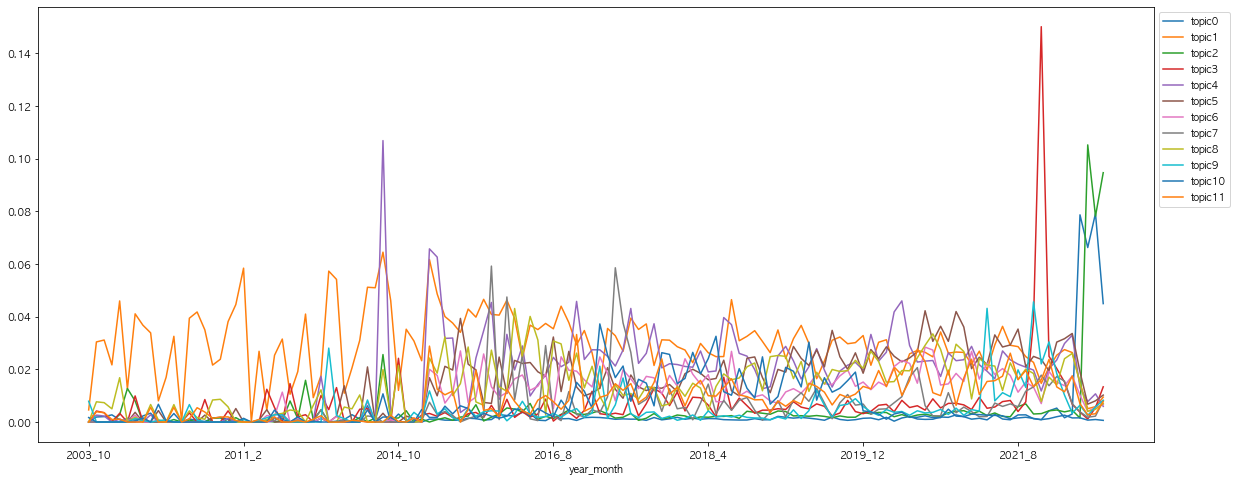

In [98]:
year_month_topic.plot(figsize=(20,8))
plt.legend(bbox_to_anchor=[1,1])
plt.show()

In [103]:
corpora_df['topic_nmf'] = doc_topics.argmax(axis=1)

topic0:


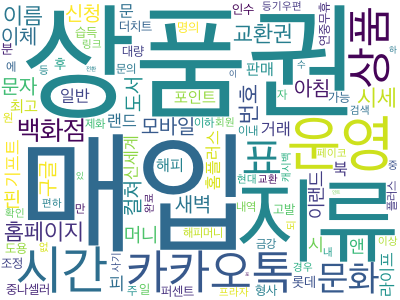

topic1:


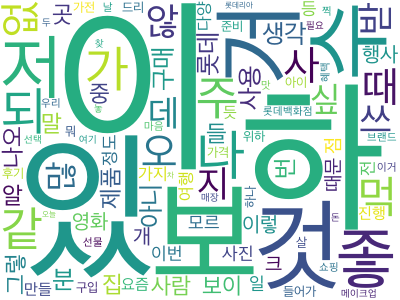

topic2:


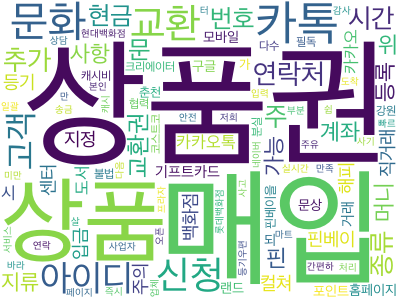

topic3:


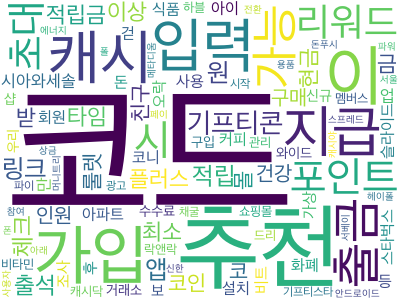

topic4:


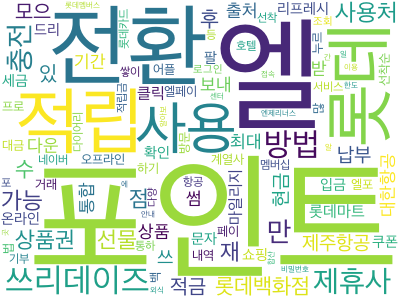

topic5:


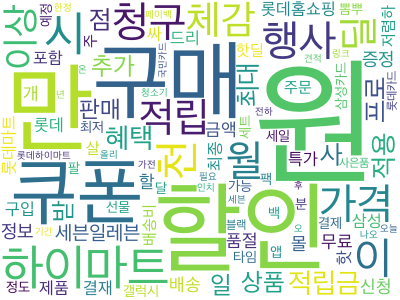

topic6:


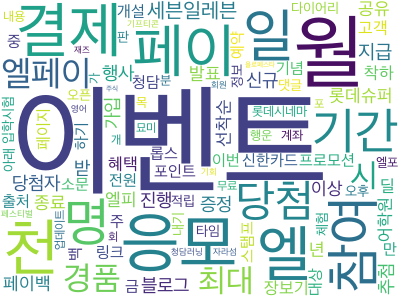

topic7:


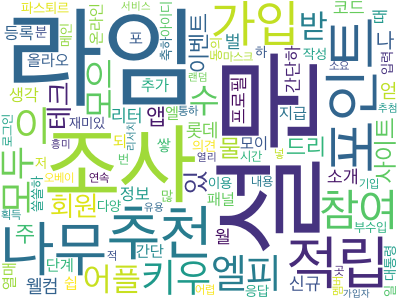

topic8:


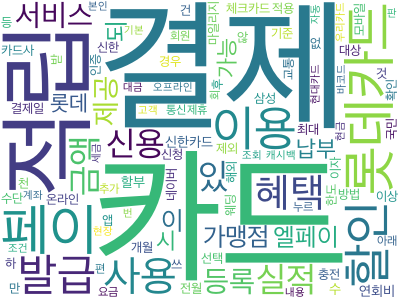

topic9:


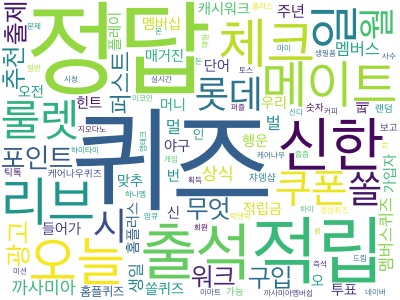

topic10:


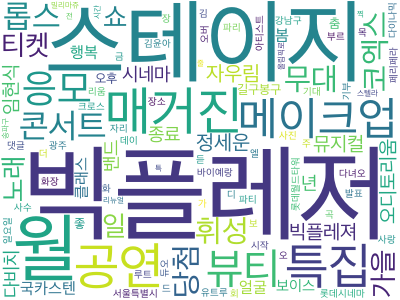

topic11:


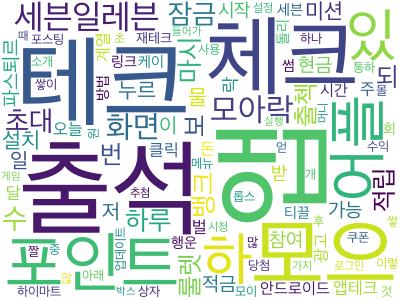

In [105]:
for i in range(12):
    globals()[f'topic{i}'] = pd.DataFrame({'word':tfidf_nv.get_feature_names_out(), 'loading':loading[i]})
    print(f'topic{i}:')
    wc = WordCloud(max_words=100, width=400, height=300, font_path='Macintosh HD/시스템/라이브러리/Fonts/AppleSDGothicNeo.ttc',
              background_color='white')
    count_dict = dict(zip(globals()[f'topic{i}']['word'], globals()[f'topic{i}']['loading']))
    cloud = wc.fit_words(count_dict)
    display(cloud.to_image())

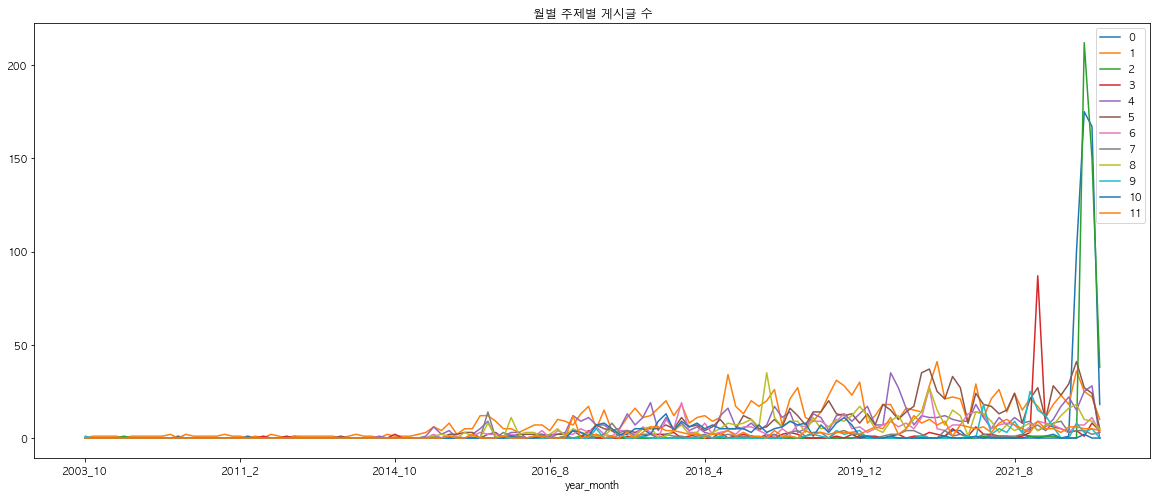

In [106]:
pd.crosstab(corpora_df.year_month, corpora_df.topic_nmf).plot(figsize=(20,8))
plt.title('월별 주제별 게시글 수')
plt.legend(bbox_to_anchor=[1,1])
plt.show()

/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


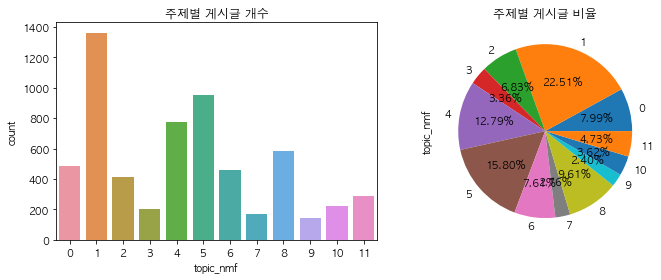

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(corpora_df.topic_nmf, ax=axes[0])
corpora_df.groupby('topic_nmf').topic_nmf.count().plot.pie(autopct='%.2f%%', ax=axes[1])
axes[0].set_title('주제별 게시글 개수')
axes[1].set_title('주제별 게시글 비율')
plt.tight_layout()
plt.show()

- 1, 5, 4, 8, 0번 주제 순으로 많음

#### LDA

In [110]:
corpus = Sparse2Corpus(tdm_nv.T)
train_corpus, test_corpus = train_test_split(corpus, test_size=0.2, random_state=0)
id2token = Dictionary([tfidf_nv.get_feature_names()])

/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [111]:
model = LdaModel(corpus=train_corpus, id2word=id2token, num_topics=12, random_state=0)
loss = model.log_perplexity(test_corpus)
old_loss = -np.inf
while loss > old_loss + 0.0001:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(test_corpus)
    print(loss)

-10.456374541626463
-10.586820097448062


In [112]:
# 주제 응집도 계산
coh = CoherenceModel(model=model, corpus=corpus, texts=[tfidf_nv.get_feature_names()], dictionary=id2token, coherence='c_v')
coh.get_coherence()

0.7913105958466619

In [113]:
# 주제 다양도 계산
topn = 25
top_words = set()
for topic in range(model.num_topics):
    for word, prob in model.show_topic(topic, topn=topn):
        top_words.add(word)
len(top_words)/(25*100)

0.1028

In [115]:
model.save('LDA_lpoint_lpay')

In [178]:
temp_file = datapath("/Users/kwon-yujin/Desktop/lpoint/LDA_lpoint_lpay")
model = LdaModel.load(temp_file)

In [179]:
for i in range(12):
    print(f'주제 {i}:')
    print(model.show_topic(i, 50))
    print()

주제 0:
[('상품권', 0.040245436), ('매입', 0.03804688), ('지류', 0.026196627), ('상품', 0.024886196), ('문화', 0.023507634), ('시간', 0.022999937), ('번호', 0.018299801), ('신청', 0.017142402), ('카카오톡', 0.017056143), ('교환권', 0.016756335), ('운영', 0.016730703), ('백화점', 0.016132347), ('홈페이지', 0.014184551), ('핀', 0.013695751), ('컬쳐', 0.012893074), ('머니', 0.012421802), ('교환', 0.012316925), ('시세', 0.012103957), ('도서', 0.01208903), ('표', 0.011896332), ('문', 0.011872372), ('카톡', 0.011226264), ('모바일', 0.011185455), ('이름', 0.010767631), ('구글', 0.010510755), ('주', 0.0099361), ('시', 0.009213779), ('새벽', 0.009004092), ('해피', 0.008758476), ('문자', 0.008692146), ('이체', 0.008650098), ('아침', 0.0086410185), ('포인트', 0.008503202), ('거래', 0.008441064), ('랜드', 0.008434164), ('아이디', 0.008384804), ('가능', 0.008233453), ('연락처', 0.007955877), ('고객', 0.007911558), ('추가', 0.0074388427), ('종류', 0.0071031656), ('라이프', 0.0068685836), ('신세계', 0.0068655023), ('북', 0.0067917514), ('홈플러스', 0.0066661583), ('앤', 0.006655929), ('기프트', 0.006468

In [166]:
pyLDAvis.enable_notebook()
p = gensimvis.prepare(model, corpus, id2token)
pyLDAvis.display(p)

/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/kwon-yujin/opt

- 크게 2개로 나뉨 (상품권 거래 vs 이벤트)
  - 1: 이벤트 관련
  - 3: 이벤트 관련
  - 2: 상품권 관련
  - 4, 6: 이벤트 관련
  - 나머지: 상품 단어가 많음